<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/2021-03-14-tabular-data-variational-autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation for tabular data

## How to create fake tabular data with a variational autoencoder to improve deep learning algorithms

To train deeplearning models the more data the better. When we're thinking of image data, the deeplearnig community thought about a lot of tricks how to enhance the model given a dataset of images. Meaning that by rotating, flipping, blurring etc. the image we can create more input data and also improve our model. 

However, when thinking about tabular data, only few of these techniques exist. In this blogpost I want to show you how to create a variational autoencoder and make use of data augmentation. I will create fake data, which is sampled from the learned distribution of the underlying data. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset Overview

In [3]:

data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [4]:
y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

43

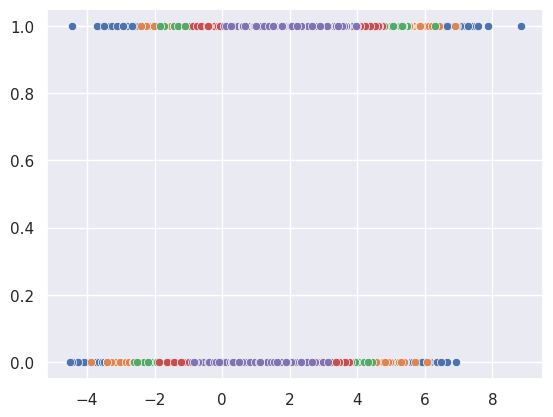

In [5]:
import seaborn as sns
sns.set()
     
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

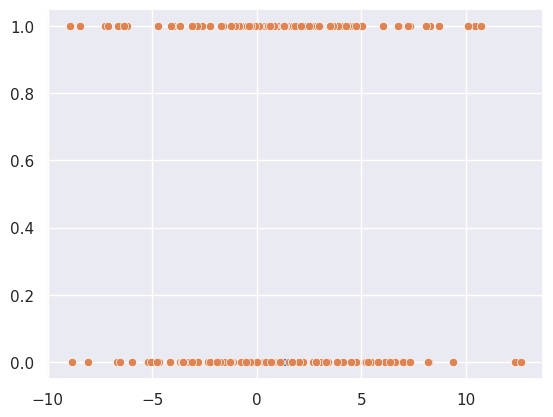

In [6]:
for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

In [7]:

columns=['x0','x1','x2','x3','z0']
df_base = pd.DataFrame(x,columns=columns)

In [8]:
df_base

,x0,x1,x2,x3,z0
0,0.719310,2.860236,1.799608,2.045636,1.583382
1,-1.165433,4.037065,2.792890,1.763522,1.277861
2,1.891618,1.548392,-0.006569,1.024710,0.322010
3,0.221565,1.218263,1.084272,0.670920,0.894882
4,-0.552163,0.372689,1.090111,-0.240047,0.696330
...,...,...,...,...,...
39995,4.562870,2.898997,2.509578,1.837898,2.520072
39996,1.061400,-0.398102,1.026086,2.443793,-6.339871
39997,3.350382,2.304473,1.505832,3.043521,-0.353732
39998,0.999688,1.661763,-0.501777,1.547128,-4.759444


In [9]:
cols = df_base.columns

## Build Data Loader

In [10]:
def load_and_standardize_data(data):
    # read in from csv
    df = data #pd.read_csv(path, sep=',')
    # replace nan with -99
    df = df.fillna(-99)
    df = df.values.reshape(-1, df.shape[1]).astype('float32')
    # randomly split
    X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   
    return X_train, X_test, scaler

In [11]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path, train=True):
        self.X_train, self.X_test, self.standardizer = load_and_standardize_data(df_base)
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len=self.x.shape[0]
        del self.X_train
        del self.X_test 
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [12]:
traindata_set=DataBuilder(df_base, train=True)
testdata_set=DataBuilder(df_base, train=False)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

In [13]:
type(trainloader.dataset.x), type(testloader.dataset.x)

(torch.Tensor, torch.Tensor)

In [14]:
trainloader.dataset.x.shape, testloader.dataset.x.shape

(torch.Size([28000, 5]), torch.Size([12000, 5]))

In [15]:
trainloader.dataset.x

tensor([[ 0.9800,  0.6530, -0.7547,  1.0818,  1.1437],
        [-0.2112,  0.3558,  0.0738, -0.3819, -0.1064],
        [ 1.2033,  1.9699,  0.5207,  0.7620, -0.1077],
        ...,
        [-0.1609, -1.3908, -0.2485, -1.5751, -0.7159],
        [ 0.4435, -1.2266, -0.2502,  0.4881,  0.0702],
        [ 0.0446,  0.1743, -0.7792,  0.0949,  0.9700]])

## Build model

In [16]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [17]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

If you want to better understand the variational autoencoder technique, look [here](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73).

For better understanding this AutoencoderClass, let me go briefly through it. This is a variational autoencoder (VAE) with two hidden layers, which (by default, but you can change this) 50 and then 12 activations. The latent factors are set to 3 (you can change that, too). So we're first exploding our initially 14 variables to 50 activations, then condensing it to 12, then to 3. From these 3 latent factors we then sample to recreate the original 14 values. We do that by inflating the 3 latent factors back to 12, then 50 and finally 14 activations (we decode the latent factors so to speak). With this reconstructed batch (recon_batch) we compare it with the original batch, computate our loss and adjust the weights and biases via our gradient (our optimizer here will be Adam). 

In [18]:
D_in = trainloader.dataset.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [19]:
loss_mse = customLoss()

## Train Model

In [20]:
epochs = 1500
log_interval = 50
val_losses = []
train_losses = []
test_losses = []

In [21]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [22]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            if epoch % 200 == 0:        
                print('====> Epoch: {} Average test loss: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [23]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

====> Epoch: 200 Average training loss: 4.3265
====> Epoch: 200 Average test loss: 0.3759
====> Epoch: 200 Average test loss: 0.7417
====> Epoch: 200 Average test loss: 1.1059
====> Epoch: 200 Average test loss: 1.4860
====> Epoch: 200 Average test loss: 1.8414
====> Epoch: 200 Average test loss: 2.1986
====> Epoch: 200 Average test loss: 2.5687
====> Epoch: 200 Average test loss: 2.9340
====> Epoch: 200 Average test loss: 3.3155
====> Epoch: 200 Average test loss: 3.6869
====> Epoch: 200 Average test loss: 4.0640
====> Epoch: 200 Average test loss: 4.3332
====> Epoch: 400 Average training loss: 4.3033
====> Epoch: 400 Average test loss: 0.3717
====> Epoch: 400 Average test loss: 0.7370
====> Epoch: 400 Average test loss: 1.1024
====> Epoch: 400 Average test loss: 1.4762
====> Epoch: 400 Average test loss: 1.8280
====> Epoch: 400 Average test loss: 2.1740
====> Epoch: 400 Average test loss: 2.5385
====> Epoch: 400 Average test loss: 2.8992
====> Epoch: 400 Average test loss: 3.2825
===

We we're able to reduce the training and test loss but quite a bit, let's have a look at how the fake results actually look like vs the real results:

In [24]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

In [26]:
scaler = trainloader.dataset.standardizer
recon_row = scaler.inverse_transform(recon_batch[0].cpu().numpy().reshape(-1,1))
real_row = scaler.inverse_transform(testloader.dataset.x[0].cpu().numpy().reshape(-1,1))

ValueError: ignored

In [29]:
recon_batch.cpu().numpy().shape

(736, 5)

In [27]:
df = pd.DataFrame(np.stack((recon_row, real_row)), columns = cols)
df

NameError: ignored

Not to bad right (the first row is the reconstructed row, the second one the real row from the data)? However, what we want is to built this row not with the real input so to speak, since right now we were giving the model the complete rows with their 14 columns, condensed it to 3 input parameters, just to blow it up again to the corresponding 14 columns. What I want to do is to create these 14 rows by giving the model 3 latent factors as input. Let's have a look at these latent variables. 

In [30]:
sigma = torch.exp(logvar/2)

In [31]:
mu[1], sigma[1]

(tensor([ 0.1132,  0.0028, -1.0532], device='cuda:0'),
 tensor([0.7076, 0.9989, 0.3893], device='cuda:0'))

Mu represents the mean for each of our latent factor values, logvar the log of the standard deviation. Each of these have a distribution by itself. We have 54 cases in our test data, so we have 3x54 different mu and logvar. We can have a look at the distribution of each of the 3 latent variables: 

In [32]:
mu.mean(axis=0), sigma.mean(axis=0)

(tensor([ 0.0023, -0.0001,  0.0045], device='cuda:0'),
 tensor([0.7085, 0.9991, 0.4831], device='cuda:0'))

All of the latent variables have a mean around zero, but the last latent factor has a wider standard deviation. So when we sample values from each of these latent variables, the last value will vary much more then the other two. I assume a normal distribution for all the latent factors.

In [33]:
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [34]:
z.shape

torch.Size([20, 3])

In [35]:
z[:5]

tensor([[-0.5541,  1.4630,  0.7221],
        [-1.6399,  0.0061,  0.0258],
        [-0.0911,  0.7751, -0.3078],
        [-0.2759, -0.4239, -0.0732],
        [-0.2365, -1.1481,  0.1015]], device='cuda:0')

With these three latent factors we can now start and create fake data for our dataset and see how it looks like:

In [36]:
with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

In [37]:
pred[1]

array([-0.886597 ,  0.6120701,  0.5488543,  0.472581 ,  0.5187014],
      dtype=float32)

## Create fake data from Autoencoder

In [38]:
fake_data = scaler.inverse_transform(pred)
fake_data.shape

(20, 5)

In [39]:
fake_data

array([[ 0.5643727 ,  0.06915203,  0.9769583 ,  0.8729925 ,  2.4251282 ],
       [ 0.10963502,  2.3064384 ,  2.0610428 ,  1.9049317 ,  2.9288285 ],
       [ 2.062392  ,  2.1900907 ,  2.236256  ,  2.1413147 ,  2.3994179 ],
       [ 1.4389079 ,  2.1087017 ,  1.9519644 ,  1.887697  ,  1.713243  ],
       [ 1.1664559 ,  1.8968394 ,  1.5384579 ,  1.5552095 ,  1.1907102 ],
       [ 2.1357193 ,  2.1453054 ,  2.0597582 ,  2.0172613 ,  1.2731706 ],
       [ 1.4771672 ,  0.9167933 ,  0.8110738 ,  0.9529538 ,  0.15696757],
       [ 4.8579144 ,  1.252751  ,  1.4174538 ,  1.7233986 ,  3.9294248 ],
       [ 2.8427982 ,  2.1318133 ,  2.162959  ,  2.1490705 ,  1.6969155 ],
       [ 1.6708935 ,  0.9233353 ,  0.7731264 ,  0.936947  , -2.0292494 ],
       [ 1.3649414 ,  1.3772943 ,  0.9709462 ,  1.1052529 ,  0.22819154],
       [ 1.4451836 ,  2.2486722 ,  2.5149484 ,  2.2573254 ,  5.8303175 ],
       [ 1.0668815 ,  2.1904984 ,  2.0363777 ,  1.9308894 ,  2.3352838 ],
       [ 0.71730614,  1.517478  ,  1.0

In [41]:
df_fake = pd.DataFrame(fake_data, columns = cols)
#df_fake['Wine'] = np.round(df_fake['Wine']).astype(int)
#df_fake['Wine'] = np.where(df_fake['Wine']<1, 1, df_fake['Wine'])
df_fake.head(10)

,x0,x1,x2,x3,z0
0,0.564373,0.069152,0.976958,0.872993,2.425128
1,0.109635,2.306438,2.061043,1.904932,2.928828
2,2.062392,2.190091,2.236256,2.141315,2.399418
3,1.438908,2.108702,1.951964,1.887697,1.713243
4,1.166456,1.896839,1.538458,1.555210,1.190710
5,2.135719,2.145305,2.059758,2.017261,1.273171
6,1.477167,0.916793,0.811074,0.952954,0.156968
7,4.857914,1.252751,1.417454,1.723399,3.929425
8,2.842798,2.131813,2.162959,2.149071,1.696916
9,1.670894,0.923335,0.773126,0.936947,-2.029249


For comparison the real data:

In [42]:
df_base.sample(10)

,x0,x1,x2,x3,z0
6669,3.891044,-1.259070,1.972639,2.361438,4.143576
6850,0.215696,1.723339,1.719764,0.881931,0.176142
1619,2.122611,3.586145,1.914136,1.291366,2.277642
36583,2.964243,3.141048,1.436922,2.544189,-2.341566
28138,1.820332,0.290076,0.873029,1.798497,5.289183
7187,-0.700981,0.539157,0.453247,0.893113,0.598477
19491,2.408445,1.924172,3.444357,2.518169,0.210121
14961,2.490460,3.557156,2.855833,2.175238,1.669200
28343,4.427120,1.257998,0.709267,1.404986,4.891127
5150,0.066273,2.460945,1.273214,0.756654,1.603505


## Compare variables grouped by Wine

In [ ]:
df_base.groupby('Wine').mean()

In [ ]:
df_fake.groupby('Wine').mean()

That looks pretty convincing if you ask me. 

To sum up, we've built a variational autoencoder, which we trained on our trainingset. We checked whether our loss kept on improving based on the testset, which the autoencoder never saw for generating fake data. We then calculated the mean and standard deviation from our latent factors given the test data. We've then sampled from this distribution to feed it back into our decoder to create some fake data. With this approach I am now able to create as much fake data derived from the underlying distribution as a want. And I think the results look promising. 

You can take this approach to for example create data from under-represented in highly skewed datasets instead of just weighting them higher. The re-weighting approach might cause the algorithm to find relations where there are none, only because a few then overrepresented data points share this relation by random. With the shown approach, the learned distribution would take into account the high variance these features have and therefore will hopefully help the algorithm to not draw these false conclusions.

Stay tuned for the next blogpost, where I will show the shown approach in exactly this use case.